In [2]:
#importing packages
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import os

/home/ma/ma_ma/ma_tofuchs/Graph-WaveNet-Mannheim/EDA/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


# Import Graphs

In [2]:
#mannheim
mann = pd.read_csv("/pfs/work9/workspace/scratch/ma_tofuchs-GraphWave-Seminar/Datasets/Mannheim/train_data/sensor_graph/adj_mx.csv", index_col = 0)
mann.index = mann.index.astype(str)
mann_adj = nx.from_pandas_adjacency(mann)

#la
with open("/pfs/work9/workspace/scratch/ma_tofuchs-GraphWave-Seminar/Datasets/Meta-LA/train_data/sensor_graph/adj_mx.pkl", "rb") as f:
    G = pickle.load(f, encoding="latin1")
la_adj = nx.from_numpy_array(G[2])

# Analyze traffic flow

In [16]:
traffic_df = pd.read_csv("timeseries_data_with-NaN.csv")
traffic_df = traffic_df.dropna()
traffic_df = traffic_df.drop(columns=traffic_df.columns[0])
#print(traffic_df.head(5))

# 1) Per‐column (node) means:
means = traffic_df.mean(axis=0, skipna=True)

# 2) Per‐column variances:
std_devs  = traffic_df.std(ddof=1)

print("Per‐node means:\n", means)
print("\nPer‐node st. devs:\n", std_devs)

Per‐node means:
 21649702       1171.596993
21649767       2208.910281
21673581        373.463514
21732938        341.047349
24555545       1541.261882
25117313        400.123683
25117359       1132.016974
27088492       1619.171193
27428132        721.199289
27428349        257.390317
61292847        183.819625
192984037       496.433236
248780653      1675.276431
268591025      1870.701746
282260231       763.819027
382656460      1205.739573
883463116       431.289735
988747917      1451.662949
1176328666      685.107048
1184512491     2742.937439
1633105688      659.503185
1652156206      908.614339
1672017001      445.864565
1946017834     1143.374378
10062245202    1649.153734
dtype: float64

Per‐node st. devs:
 21649702        735.256044
21649767       1114.306008
21673581        229.025496
21732938        348.231677
24555545        959.069653
25117313        262.385936
25117359        897.159190
27088492        939.932598
27428132        440.463861
27428349        152.254742
61

In [ ]:
#investigate where the zeros occur here

# load
df = pd.read_csv("timeseries_data_with-NaN.csv")

# if your time-column isn’t named, rename it:
df = df.rename(columns={df.columns[0]: "timestamp"})

# find all zeros
is_zero = df.iloc[:, 1:].eq(0)  # bool DataFrame [rows × sensors]

# for each sensor, list the timestamps where it's zero
zero_times = {
    sensor: df.loc[is_zero[sensor], "timestamp"].tolist()
    for sensor in is_zero.columns
}

# print a summary
for sensor, times in zero_times.items():
    if times:
        print(f"Sensor {sensor} is zero at {len(times)} timestamps, e.g.:")
        print("   ", times[:5], "…")
    else:
        print(f"Sensor {sensor} never zero.")

Sensor 21649702 never zero.
Sensor 21649767 never zero.
Sensor 21673581 never zero.
Sensor 21732938 is zero at 287 timestamps, e.g.:
    ['2023-03-07 02:00:00', '2023-03-07 03:00:00', '2023-04-27 19:00:00', '2023-05-07 15:00:00', '2023-05-13 00:00:00'] …
Sensor 24555545 is zero at 81 timestamps, e.g.:
    ['2023-03-04 04:00:00', '2023-03-04 23:00:00', '2023-03-05 03:00:00', '2023-03-05 04:00:00', '2023-03-05 06:00:00'] …
Sensor 25117313 never zero.
Sensor 25117359 never zero.
Sensor 27088492 never zero.
Sensor 27428132 never zero.
Sensor 27428349 never zero.
Sensor 61292847 never zero.
Sensor 192984037 never zero.
Sensor 248780653 never zero.
Sensor 268591025 never zero.
Sensor 282260231 never zero.
Sensor 382656460 is zero at 3 timestamps, e.g.:
    ['2024-01-08 02:00:00', '2024-01-10 03:00:00', '2024-01-14 04:00:00'] …
Sensor 883463116 never zero.
Sensor 988747917 never zero.
Sensor 1176328666 is zero at 13 timestamps, e.g.:
    ['2023-09-05 17:00:00', '2023-09-05 18:00:00', '2023-09

# Sparse Adj. Matrixies 

In [3]:
G = mann_adj  # e.g. nx.read_gpickle("mannheim_graph.gpickle")

# 2. Choose your Laplacian‐threshold τ
tau = 0.2

# 3. Fix a consistent node ordering
nodes = list(G.nodes())

# 4. Compute the normalized Laplacian matrix L (dense)
#    L[i,j] = -A[i,j]/sqrt(d_i d_j) for i≠j,  L[i,i]=1
L = nx.normalized_laplacian_matrix(G, nodelist=nodes).toarray()

# 5. Build a pruned copy of G
G_sparse_2 = nx.Graph()
G_sparse_2.add_nodes_from(G.nodes(data=True))

# 6. Re‐add only those edges whose |L_ij| ≥ τ
for i, u in enumerate(nodes):
    for j in range(i+1, len(nodes)):
        v = nodes[j]
        if G.has_edge(u, v):
            if abs(L[i, j]) >= tau:
                # preserve the original weight attribute if present
                w = G[u][v].get('weight', 1.0)
                G_sparse_2.add_edge(u, v, weight=w)

# 7. Inspect
print("Original:", G.number_of_nodes(), "nodes,", G.number_of_edges(), "edges")
print("Pruned:  ", G_sparse_2.number_of_nodes(), "nodes,", G_sparse_2.number_of_edges(), "edges")

Original: 25 nodes, 113 edges
Pruned:   25 nodes, 10 edges


In [4]:
G = mann_adj  # e.g. nx.read_gpickle("mannheim_graph.gpickle")

# 2. Choose your Laplacian‐threshold τ
tau = 0.1

# 3. Fix a consistent node ordering
nodes = list(G.nodes())

# 4. Compute the normalized Laplacian matrix L (dense)
#    L[i,j] = -A[i,j]/sqrt(d_i d_j) for i≠j,  L[i,i]=1
L = nx.normalized_laplacian_matrix(G, nodelist=nodes).toarray()

# 5. Build a pruned copy of G
G_sparse = nx.Graph()
G_sparse.add_nodes_from(G.nodes(data=True))

# 6. Re‐add only those edges whose |L_ij| ≥ τ
for i, u in enumerate(nodes):
    for j in range(i+1, len(nodes)):
        v = nodes[j]
        if G.has_edge(u, v):
            if abs(L[i, j]) >= tau:
                # preserve the original weight attribute if present
                w = G[u][v].get('weight', 1.0)
                G_sparse.add_edge(u, v, weight=w)

# 7. Inspect
print("Original:", G.number_of_nodes(), "nodes,", G.number_of_edges(), "edges")
print("Pruned:  ", G_sparse.number_of_nodes(), "nodes,", G_sparse.number_of_edges(), "edges")

Original: 25 nodes, 113 edges
Pruned:   25 nodes, 48 edges


In [5]:
#save the new adj matrixies 
tau_1_adj = nx.to_pandas_adjacency(G_sparse)
#tau_1_adj.to_csv("adj_sparse_1.csv", index=True)

tau_2_adj = nx.to_pandas_adjacency(G_sparse_2)
#tau_2_adj.to_csv("adj_sparse_2.csv", index=True)


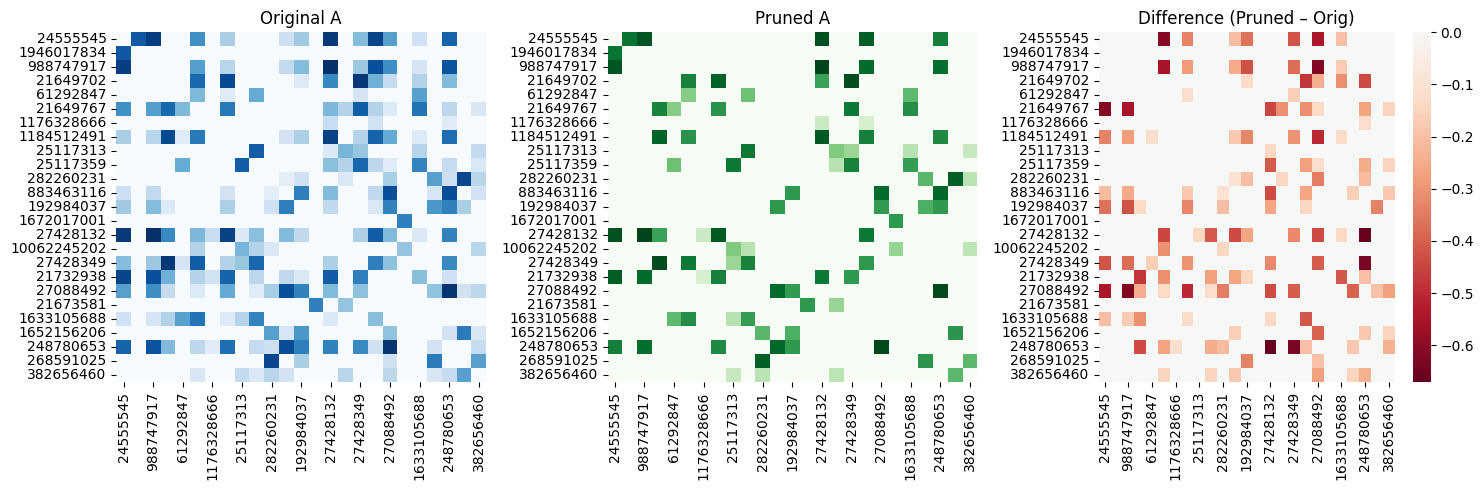

In [25]:

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))

sns.heatmap(mann, cmap="Blues",    ax=ax1, cbar=False)
ax1.set_title("Original A")

sns.heatmap(tau_1_adj, cmap="Greens",   ax=ax2, cbar=False)
ax2.set_title("Pruned A")

sns.heatmap(tau_1_adj - mann, cmap="RdBu", ax=ax3, center =0)
ax3.set_title("Difference (Pruned – Orig)")

plt.tight_layout()
plt.show()

In [18]:
#save the diff adj mx 
matrices = {
    "tau1": tau_1_adj,
    "mann": mann
}

outdir = "/home/ma/ma_ma/ma_tofuchs/Graph-WaveNet-Mannheim/embeddings"
os.makedirs(outdir, exist_ok=True)

for name, mx in matrices.items():
    # normalize
    #normed = mx * (1/np.max(mx))
    mx = mx / mx.max()

    # make a fresh figure
    plt.figure(figsize=(6,6))

    # optional: set your own tick‐labels if the indices are too large

    print(mx.sum(axis=1))
    sns.heatmap(mx, cmap="Greens")

    plt.title(f"{name} adaptive adjacency (normalized)")

    # save with the actual matrix name
    plt.savefig(f"{outdir}/{name}.pdf")
    plt.close()

24555545       4.721271
1946017834     0.875391
988747917      3.816919
21649702       3.572932
61292847       1.923579
21649767       4.244407
1176328666     0.445754
1184512491     4.383214
25117313       3.267714
25117359       4.318059
282260231      2.318047
883463116      2.804110
192984037      3.039354
1672017001     1.000000
27428132       5.576158
10062245202    2.023692
27428349       4.191322
21732938       5.060395
27088492       2.974855
21673581       1.862565
1633105688     3.091040
1652156206     2.259478
248780653      5.506004
268591025      3.000000
382656460      1.864094
dtype: float64


24555545       7.926203
1946017834     0.875391
988747917      7.026881
21649702       5.437013
61292847       2.226199
21649767       7.645259
1176328666     0.570969
1184512491     6.958007
25117313       3.409646
25117359       5.697995
282260231      3.621218
883463116      4.907317
192984037      5.392346
1672017001     1.000000
27428132       9.395059
10062245202    2.569229
27428349       7.077500
21732938       7.587659
27088492       7.868356
21673581       1.862565
1633105688     4.551024
1652156206     3.321903
248780653      9.651960
268591025      3.695831
382656460      3.192165
dtype: float64


# Graph Theory

In [7]:
# Replace these with your actual graphs
graphs = {
    "METR-LA": la_adj,
    "Mannheim": mann_adj, #,
    "Mannheim t=.2": G_sparse_2, 
    "Mannheim t=.1": G_sparse
    #"PEMS-BAY": pems_graph
}

def spectral_gap(G):
    A = nx.to_numpy_array(G)
    eigs = np.real(np.linalg.eigvals(A))
    eigs_sorted = np.sort(eigs)[::-1]
    return eigs_sorted[0] - eigs_sorted[1]

def algebraic_connectivity(G):
    # normalized Laplacian
    L = nx.normalized_laplacian_matrix(G).toarray()
    eigs = np.real(np.linalg.eigvals(L))
    eigs_sorted = np.sort(eigs)
    return eigs_sorted[1]  # Fiedler value

for name, G in graphs.items():
    V = G.number_of_nodes()
    E = G.number_of_edges()
    avg_deg = 2 * E / V
    avg_clust = nx.average_clustering(G, weight='weight')
    gap = spectral_gap(G)
    fiedler = algebraic_connectivity(G)
    print(f"--- {name} ---")
    print(f" Nodes               : {V}")
    print(f" Edges               : {E}")
    print(f" Average degree      : {avg_deg:.2f}")
    print(f" Average clustering  : {avg_clust:.3f}")
    print(f" Spectral gap        : {gap:.3f}")
    print(f" Algebraic connectivity (Fiedler) : {fiedler:.3f}")
    print()

--- METR-LA ---
 Nodes               : 207
 Edges               : 1520
 Average degree      : 14.69
 Average clustering  : 0.221
 Spectral gap        : 1.643
 Algebraic connectivity (Fiedler) : 0.000

--- Mannheim ---
 Nodes               : 25
 Edges               : 113
 Average degree      : 9.04
 Average clustering  : 0.249
 Spectral gap        : 3.371
 Algebraic connectivity (Fiedler) : 0.153

--- Mannheim t=.2 ---
 Nodes               : 25
 Edges               : 10
 Average degree      : 0.80
 Average clustering  : 0.073
 Spectral gap        : 0.539
 Algebraic connectivity (Fiedler) : 0.000

--- Mannheim t=.1 ---
 Nodes               : 25
 Edges               : 48
 Average degree      : 3.84
 Average clustering  : 0.303
 Spectral gap        : 1.162
 Algebraic connectivity (Fiedler) : 0.091



def knn_prune(A: pd.DataFrame, k: int) -> pd.DataFrame:
    # Make an all-zero DataFrame of the same shape
    A_knn = pd.DataFrame(0, index=A.index, columns=A.columns)
    
    for u in A.index:
        # Sort neighbors of u by weight descending, pick top k (excluding self)
        topk = A.loc[u].nlargest(k+1).index.drop(u, errors='ignore')[:k]
        A_knn.loc[u, topk] = A.loc[u, topk]
    
    # Symmetrize: only keep edges if either direction selected
    A_sym = pd.DataFrame(
        np.maximum(A_knn.values, A_knn.values.T),
        index=A.index, columns=A.columns
    )
    return A_sym

# Example: keep each node’s top-5 edges
knn_sparse = knn_prune(mann, k=5)